In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#READING AND VIEWING THE DATA
#Import all that we need for text classification
from fastai.text import * 

In [4]:
#dataset link which is mounted from drive
df = pd.read_csv("/content/drive/My Drive/emotion.data")
#drop null records if any
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
#display first few records in the dataset
df.head()

,id,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [5]:
#splitting of data in 80:20 ratio
train_df, valid_df = df.loc[:333447,:], df.loc[333447:,:]
len(train_df), len(valid_df)

(333448, 83362)

In [6]:
#GETTING DATA READY FOR MODELING
#Pretrained Language model is used to get the representation of full sentences or documents rather than using word embeddings only for words upto 300 or 400 floats
#Storing data in objects such as data_lm and data_clas accordingly for language and classifier models.This will also handle all the pre-processing methods
data_lm = TextLMDataBunch.from_df(Path("/content/drive/My Drive/data/train"), train_df, valid_df, text_cols=1, bs=32)
data_clas = TextClasDataBunch.from_df(Path("/content/drive/My Drive/data/train"), train_df, valid_df, text_cols=1, label_cols=2, bs=32)

In [7]:
#View data to be provided in language model
data_lm.show_batch()

idx,text
0,few days back xxbos i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate xxbos i find myself frustrated with christians because i feel that there is constantly a talk about loving one another being there for each other and praying for each other and i have seen that this is not always the case xxbos i am one of those people
1,feeling of guilt whether i am innocent or xxunk xxbos i must want you what you might read or see here from now on might make you feel disturbed or disgust if you re a sensitive person do nt scroll down xxbos i feel rather selfish and spoiled for even using such a term but it is what it is xxbos i d not long turned when i got pregnant
2,hard during their days but going to bed with satisfied smiles on their faces xxbos i feel dis respected xxbos i left the gym feeling content xxbos i feel like life is back in my face and never did i realize how many precious little moments i was missing xxbos i feel the passion heat my soul igniting the fire within my body trembles at your touch aching for your
3,short end of the stick there xxbos i ca nt help but feel nostalgic and a little bit down xxbos i feel that rushed prize giving really dilute the event and in future prize xxunk will be not rushed and will be on timetable xxbos i ve decided that its time to stop feeling guilty about my lack of recent posting activity on this blog xxbos i feel like that
4,am already feeling lost without it xxbos i feel very privileged to be able to help them out by providing them with high quality and sometimes very different images to use in their publicity and fund raising xxbos i found myself tongue tied and blanked out i too would look around only to see all perfect souls around only to experience that deep hole in my soul my terrible personality


In [8]:
#view data to be provided in classifier model
data_clas.show_batch()


text,target
xxbos two years back someone invited me to be the tutor of her granddaughter the granddaughter asked me some questions in mathematics so i taught her however she did not listen to me and this made me feel unhappy the second year it was the same when i entered university the girls parents suggested that i be employed as their xxunk tutor they told me that at university there was,anger
xxbos i feel so good is gon na move me so close to you i feel so safe i could go all the way with you when the night is gon na get to you we re gon na scream my love even dance forever and i m gon na be in your groove i m gon na dance with you until the night comes to an end,joy
xxbos i feel that i always have to shift to focus on their needs and it makes me mad because i just lost xxunk and ca nt they see my only flesh and blood is gone and i m a wreck and i ca nt accept that she will never be here and they need me but i ca nt be there for them now,anger
xxbos i was nt listening to it when the sandwich burned my mouth and i did nt look out the window and let my heart lift with the song just for the few beats breath in real and feel the floorboards under my feet and the little boy on his bike next door but maybe you can afford me a bit of artistic license,joy
xxbos i had arranged with a friend to go with him to carinthia by car we had arranged a place where to meet i was a bit late and my friend had left already i had no money to go by train i nearly started to cry because i was so angry it was very important for me to go to carinthia,anger


In [9]:
#FINE-TUNING A LANGUAGE MODEL
#Use the data_lm object we created earlier to fine-tune a pretrained language model.The created learner object will create a model,download the pretrained weights and be ready for fine-tuning.
learn = language_model_learner(data_lm,AWD_LSTM,pretrained=True, drop_mult=0.3)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


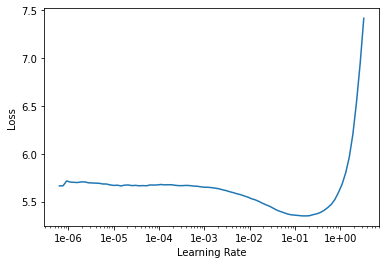

In [11]:
#Find the learing rate and plot the learning rate against loss
learn.lr_find()
learn.recorder.plot()

In [12]:
#fine-tuning,By default all the pre trained layers are frozen so explicit freezing not required hence we can directly train the model which is possible only in fastai
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.227544,4.122668,0.290295,06:13


In [0]:
#Unfreeze the model before retraining it
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


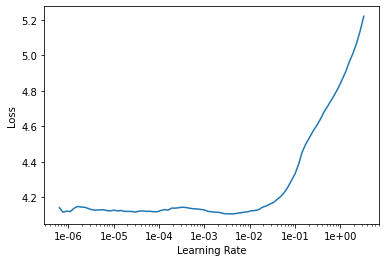

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.961130,3.975419,0.305651,06:19
1,3.922503,3.911452,0.312777,06:21
2,3.864867,3.878265,0.317159,06:19
3,3.806913,3.852423,0.320532,06:26
4,3.731308,3.842258,0.322706,06:22
5,3.661532,3.830856,0.324893,06:22
6,3.592135,3.826967,0.325907,06:19
7,3.520828,3.830978,0.326529,06:23
8,3.455573,3.838800,0.326630,06:24
9,3.433436,3.842429,0.326514,06:22


In [0]:
learn.save('lm')

In [0]:
#Save it for future purpose i.e. To provide it to the classification model
learn.save_encoder('lm-enc')


In [18]:
#Builds a classifier with our fine-tuned encoder
learn = text_classifier_learner(data_clas,AWD_LSTM,pretrained=True ,drop_mult=0.3)
learn.load_encoder('lm-enc')



RNNLearner(data=TextClasDataBunch;

Train: LabelList (333448 items)
x: TextList
xxbos i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here,xxbos i m alone i feel awful,xxbos i ve probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years resolution of monthly and weekly goals,xxbos i was feeling a little low few days back,xxbos i beleive that i am much more sensitive to other peoples feelings and tend to be more compassionate
y: CategoryList
sadness,sadness,joy,sadness,love
Path: /content/drive/My Drive/data/train;

Valid: LabelList (83362 items)
x: TextList
xxbos i ve been feeling a little needy and wistful the last few days,xxbos i am greatly flattered to be tagged by her though i feel a little apprehensive as well,xxbos i feel jelly is delicious coming,xxbos i feel like for me it brings loving to a whole new level,xxbos i feel that i have resolved some deeply rooted issues


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


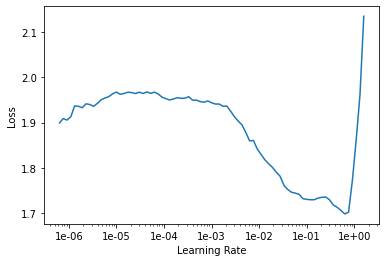

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.970765,0.829200,0.685324,05:38


In [21]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.165596,0.095178,0.939385,07:20
1,0.124287,0.090765,0.939937,07:24


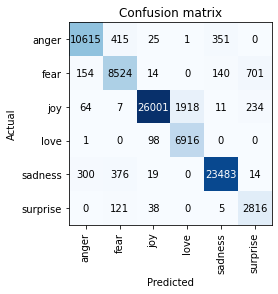

In [22]:
#Plotting confusion matrix to analyse the results
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [23]:
interp.most_confused()

[('joy', 'love', 1918),
 ('fear', 'surprise', 701),
 ('anger', 'fear', 415),
 ('sadness', 'fear', 376),
 ('anger', 'sadness', 351),
 ('sadness', 'anger', 300),
 ('joy', 'surprise', 234),
 ('fear', 'anger', 154),
 ('fear', 'sadness', 140),
 ('surprise', 'fear', 121),
 ('love', 'joy', 98),
 ('joy', 'anger', 64),
 ('surprise', 'joy', 38),
 ('anger', 'joy', 25),
 ('sadness', 'joy', 19),
 ('fear', 'joy', 14),
 ('sadness', 'surprise', 14),
 ('joy', 'sadness', 11),
 ('joy', 'fear', 7),
 ('surprise', 'sadness', 5),
 ('anger', 'love', 1),
 ('love', 'anger', 1)]